  ### 连接设备

In [1]:
import time
import numpy as np
import qulab_toolbox.wavedata as WD
import matplotlib.pyplot as plt
import ctypes
import zerorpc
import xlwt
import os
from CTP100_Dev_20230713 import ZW_CTP100_Dev
import seaborn as sns
import pandas as pd
import math
import datetime

server_ip = '192.168.1.180:8501'
dev = zerorpc.Client()
try:
    dev.connect('tcp://' + server_ip)
    if dev.my_status() in ['ok']:
        print('rpc connect ok')
except:
    print('rpc connect error')

dev_ctp = ZW_CTP100_Dev('192.168.1.200')

rpc connect ok


### 设备初始化 6-13通道8G采样率

In [2]:
#QA的4个AD通道不支持修改采样率！！！
sampling = 8000  #MHz
#0~5个DA通道共用一个采样率
dev.rfdac_sampling(sampling,0)
#6~13个DA通道共用一个采样率
dev.rfdac_sampling(sampling,6)
#14~21个DA通道共用一个采样率
dev.rfdac_sampling(sampling,14)
#设置所有DA通道奈奎斯特域
#DA Nyquist域，1: 第二奈奎斯特域，0：第一奈奎斯特域
Nyquist = 1
#0~5个DA通道共用一个奈奎斯特域设置
dev.rfdac_SetNyquistZone(Nyquist,0)
#6~13个DA通道共用一个奈奎斯特域设置
dev.rfdac_SetNyquistZone(Nyquist,6)
#14~21个DA通道共用一个奈奎斯特域设置，Z-PULSE通道通常设置成0
dev.rfdac_SetNyquistZone(0,14)


def set_freq_con(chennel_num, fout, datalen_s, amp=1, delay = 0e-9,phi = 0 ):
    sampleRate=8e9
    fs_fout = sampleRate/256/1024
    fout = fout * 1e6

    fout_wr = (fout//fs_fout)*fs_fout # dac_data_continue
    datalen = datalen_s # 50ns #30*1024/sampleRate # point*(1/sampleRate)
    sin1=WD.Sin(fout_wr*2*np.pi,phi,datalen,sampleRate)*(2**13-1) * amp
    dac_data = np.int16(sin1.data)
    dac_data = dac_data.tolist()
    da_trigger_delay = int(delay*sampleRate)
    replay_times = 100000
    replay_continue = 1
    dev.dac_updata(chennel_num,da_trigger_delay,replay_times,replay_continue,dac_data)


def set_freq(chennel_num, fout, datalen_s, amp=1, delay = 0e-9,phi = 0 ):
    sampleRate=8e9
    fs_fout = sampleRate/256/1024
    fout = fout * 1e6

    fout_wr = (fout//fs_fout)*fs_fout # dac_data_continue
    datalen = datalen_s # 50ns #30*1024/sampleRate # point*(1/sampleRate)
    sin1=WD.Sin(fout*2*np.pi,phi,datalen,sampleRate)*(2**13-1) * amp
    dac_data = np.int16(sin1.data)
    dac_data = dac_data.tolist()
    da_trigger_delay = int(delay*sampleRate)
    replay_times = 100000
    replay_continue = 0
    dev.dac_updata(chennel_num,da_trigger_delay,replay_times,replay_continue,dac_data)


def set_freq_xy_gauss(chennel_num, fout, datalen_s, amp=1,delay =10e-9,phi = 0):
    sampleRate=8e9
    fs_fout = sampleRate/256/1024
    fout = fout * 1e6

    fout_wr = (fout//fs_fout)*fs_fout # dac_data_continue
    datalen = datalen_s # 50ns #30*1024/sampleRate # point*(1/sampleRate)
    sin1=WD.Sin(fout*2*np.pi,phi,datalen,sampleRate)
    gaussian = WD.Gaussian2(datalen,sampleRate,a=5)
    data = (gaussian.data * sin1.data)*(2**13-1) * amp
    # plt.figure(0)
    # plt.plot(gaussian.data)
    # plt.figure(1)
    # plt.plot(sin1.data[0:50])
    dac_data = np.int16(data)
    dac_data = dac_data.tolist()
    # plt.figure(2)
    # plt.plot(dac_data)
    # plt.show()
    da_trigger_delay = int(delay*sampleRate)
    # print(da_trigger_delay)
    replay_times = 100000
    replay_continue = 0
    dev.dac_updata(chennel_num,da_trigger_delay,replay_times,replay_continue,dac_data)


def set_xy_two_pluse_t_gauss(chennel_num, fout, datalen_s,  amp=1, t_s=0, t_delay =10e-9):
    alltime = datalen_s * 2 + t_s
    # print(alltime*1e9)
    assert alltime < 30e-6, "pluse length is over [30us]"
    sampleRate=8e9
    fs_fout = sampleRate/256/1024
    fout = fout * 1e6

    fout_wr = (fout//fs_fout)*fs_fout # dac_data_continue
    # print(fout_wr)
    # fout_wr = fout # dac_data_continue
    datalen = datalen_s # 50ns #30*1024/sampleRate # point*(1/sampleRate)

    # # 第一个脉冲
    # sin1=WD.Sin(fout_wr*2*np.pi,0,datalen,sampleRate)
    # gaussian1 = WD.Gaussian2(datalen,sampleRate,a=5)
    # data1 = (gaussian1.data * sin1.data)*(2**13-1) * amp

    # # t时间
    # t_data2 = np.zeros(int(t_s*sampleRate))*(2**13-1) * amp

    # # 第二个脉冲
    # gaussian2 = WD.Gaussian2(datalen,sampleRate,a=5)
    # sin2=WD.Sin(fout_wr*2*np.pi, np.pi*5e6*t_s, datalen,sampleRate) # 第二个脉冲添加相位 phi = 2*pi*5MHZ*t_s  2*np.pi*5e6*t_s
    # data3 = (gaussian2.data * sin2.data)*(2**13-1) * amp

    # data = data1.tolist() + t_data2.tolist() + data3.tolist()

    sin1 = WD.Sin(fout*2*np.pi, 0, alltime, sampleRate)
    gaussian1 = WD.Gaussian2(datalen,sampleRate,a=5)
    t = np.zeros(math.ceil(t_s*sampleRate))
    gaussian2 = WD.Gaussian2(datalen,sampleRate,a=5)

    length = len(gaussian1.data.tolist()) + len(t.tolist()) + len(gaussian2.data.tolist())
    if length > len(sin1.data.tolist()):
        t1 = np.zeros(len(t)-1)
    elif length < len(sin1.data.tolist()):
        t1 = np.append(t,np.zeros(1))
    else:
        t1 = t
    wave = gaussian1.data.tolist() + t1.tolist() + gaussian2.data.tolist()
    
    data = wave * sin1.data *(2**13-1) * amp

    # 把组合后的脉冲数据发送给设备
    dac_data = np.int16(data)
    dac_data = dac_data.tolist()
    # plt.figure(2)
    # plt.plot(dac_data)
    # plt.show()
    da_trigger_delay = int(t_delay*sampleRate)
    replay_times = 100000
    replay_continue = 0
    dev.dac_updata(chennel_num,da_trigger_delay,replay_times,replay_continue,dac_data)




### 参数标定 调试

#### 延时标定

In [ ]:
def delay_test(start_mhz, end_mhz, step_mhz, datalen_s=50e-9,ad_len = 100e-9):
    IQ_COMPLEX_DATA = [] 
    IQ_COMPLEX_DATA2 = []
    dev.dac_close(0)
    dev.dac_close(14)
    dev.set_ch_offset(14, 0)
    
    for delay in np.linspace(start_mhz, end_mhz, int(abs(end_mhz - start_mhz)//step_mhz) + 1):
        dev.trigger_close()
        dev_ctp.trigger_close()
        freq = 7070
        set_freq(5, freq, datalen_s, amp=1)

        ad_trigger_delay = int(delay*2.5e9 ) #AD采集延迟，样点数量，用户可以根据采样率5Gsps和时间计算取整后得到
        shots = 2000            #解模次数
        mul_start_phase = 0     #解模参数：初相
        mul_f_freq = (freq) * 1e6    #解模参数：频率，一般每个qubit对应不同频率
        mul_f_len = int(ad_len* 2.5e9)       #解模参数：单次解模shot数据样点数量 

        mul_f = [[mul_start_phase, mul_f_freq]]    #解模参数列表，最多32组，对应一条线路上的32qubit
        dev.rd_adc_mul_data_ctrl(1,ad_trigger_delay,shots,mul_f_len,mul_f)
        save_len =  1024 #int(100e-9*2.5e9) # 单一通道集样点总长度，最大2**17

        trigger_source = 1    #触发来源，1为外部触发，0为内部触发
        trigger_us = 50      #内部触发周期，us
        trigger_num = 10      #内部触发次数
        trigger_continue = 0  #内部触发连续触发模式，1开启，0关闭

        #开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
        trigger_parameter = {
            'trigger_source':0,
            'trigger_continue':trigger_continue,
            'trigger_block_en':1,
            'trigger_ref':0,
            'trigger_times':shots,
            'trigger_us':trigger_us,
            'trigger_delay':0
        }
        dev.trigger_ctrl(trigger_source,trigger_us,shots,trigger_continue)
        dev_ctp.trigger_ctrl(1,trigger_parameter)
        dev_ctp.trigger_open()
        time.sleep(0.001)

        #稍作延迟
        time.sleep(0.001)

        while 1:
            mul_data_bufe,read_data_len = dev.rd_adc_mul_data(1,0,shots)
            if read_data_len != -1:
                break
            
        for i in range(read_data_len):
            mul_data_bufe[i] = complex(mul_data_bufe[i])

        
        IQ_COMPLEX_DATA.append(np.mean(mul_data_bufe))
        IQ_COMPLEX_DATA2 = np.asarray(IQ_COMPLEX_DATA) /mul_f_len / (2**13-1)
    return IQ_COMPLEX_DATA2

In [ ]:
# start_mhz,end_mhz,step_mhz = 6714,6719,0.05
start_mhz,end_mhz,step_mhz = 0e-9,800e-9,5e-9
delay_mod = delay_test(start_mhz, end_mhz, step_mhz, datalen_s=400e-9,ad_len = 50e-9)
x = np.linspace(start_mhz, end_mhz, int(abs(end_mhz - start_mhz)//step_mhz) + 1)*1e9
mod = np.abs(delay_mod)
now_time = datetime.datetime.now().strftime('%H_%M_%S')
plt.plot(x,mod)
plt.title("delay_test")
plt.xlabel('delay/ns')
plt.ylabel('mod')#
plt.show()
d = {'delay':x, 'y_mod':mod}
df = pd.DataFrame(data=d)
df.to_csv(f'./data_qcs/cavity_freq/delay_test_{now_time}.csv')

#### 原始数据画波形

In [2]:
def sweep_qa_amp_xxx(start_amp, end_amp, step_amp, channel=5, datalen_s=200e-9):
    IQ_COMPLEX_DATA = []
    for amp in np.linspace(start_amp, end_amp, int(abs(end_amp - start_amp)//step_amp) + 1):
        dev.trigger_close()
        dev_ctp.trigger_close()
        delay = 10e-9
        set_freq(5, 7092.62, datalen_s, 1,delay=0e-9)
        # set_freq(6, 3775, 12e-6, amp , delay=0e-9)
        ad_fixed_delay = int(250e-9*2.5e9)
        ad_trigger_delay = ad_fixed_delay   + delay * 2.5e9#AD采集延迟，样点数量，用户可以根据采样率5Gsps和时间计算取整后得到datalen_s*2.5e9
        shots = 1024           #解模次数
        dev.rd_adc_data_ctrl(1, ad_trigger_delay, 1, 8000)

        trigger_source = 1    #触发来源，1为外部触发，0为内部触发
        trigger_us = 100      #内部触发周期，us
        trigger_num = 10      #内部触发次数
        trigger_continue = 0  #内部触发连续触发模式，1开启，0关闭

        #开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
        trigger_parameter = {
            'trigger_source':0,
            'trigger_continue':trigger_continue,
            'trigger_block_en':1,
            'trigger_ref':0,
            'trigger_times':shots,
            'trigger_us':trigger_us,
            'trigger_delay':0
        }
        dev.trigger_ctrl(trigger_source,trigger_us,shots,trigger_continue)
        dev_ctp.trigger_ctrl(1,trigger_parameter)
        dev_ctp.trigger_open()
        time.sleep(0.1)

        #稍作延迟
        time.sleep(0.1)

        adc_data_buf, save_len_i = dev.rd_adc_data(1, 1, 8000)

        adc_data_w = []
        data_w = np.kaiser(save_len_i, 8)
        adc_data_w = adc_data_buf
        adc_data_w = adc_data_w * data_w
        # my_fft_num(adc_data_w)
        # plt.plot(adc_data_buf[0:500])
        plt.plot(adc_data_buf[0:1000])
        plt.show()

        # 
        # while 1:
        #     mul_data_bufe,read_data_len = dev.rd_adc_mul_data(1,0,shots)
        #     if read_data_len != -1:
        #         break
            
        # for i in range(read_data_len):
        #     mul_data_bufe[i] = complex(mul_data_bufe[i])

        # IQ_COMPLEX_DATA.append(np.mean(mul_data_bufe))

    return IQ_COMPLEX_DATA

In [ ]:
start_amp, end_amp, step_amp = 0.1, 1,10 
IQ_COMPLEX_DATA = sweep_qa_amp_xxx(start_amp, end_amp, step_amp, channel=5, datalen_s=12000e-9)
# IQ_COMPLEX_DATA2 = np.asarray(IQ_COMPLEX_DATA) / 2**10 / 8192
# maxvalue = np.max(IQ_COMPLEX_DATA2)
# IQ_COMPLEX_DATA3 = IQ_COMPLEX_DATA2
# x = np.linspace(start_amp, end_amp, int(abs(end_amp - start_amp)//step_amp) + 1)
# mod = np.abs(IQ_COMPLEX_DATA3)
# plt.plot(x, mod)
# plt.show()

#### 采样率切换

In [ ]:
#QA的4个AD通道不支持修改采样率！！！
sampling = 8000  #MHz
#0~5个DA通道共用一个采样率
dev.rfdac_sampling(sampling,0)
#6~13个DA通道共用一个采样率
dev.rfdac_sampling(9600,6)
#14~21个DA通道共用一个采样率
dev.rfdac_sampling(sampling,14)
#设置所有DA通道奈奎斯特域
#DA Nyquist域，1: 第二奈奎斯特域，0：第一奈奎斯特域
Nyquist = 1
#0~5个DA通道共用一个奈奎斯特域设置
dev.rfdac_SetNyquistZone(Nyquist,0)
#6~13个DA通道共用一个奈奎斯特域设置
dev.rfdac_SetNyquistZone(0,6)
#14~21个DA通道共用一个奈奎斯特域设置，Z-PULSE通道通常设置成0
dev.rfdac_SetNyquistZone(0,14)

def set_freq_con_6_13(chennel_num, fout, datalen_s, amp=1, delay = 0e-9,phi = 0 ):
    sampleRate=9.6e9
    fs_fout = sampleRate/256/1024
    fout = fout * 1e6

    fout_wr = (fout//fs_fout)*fs_fout # dac_data_continue
    datalen = datalen_s # 50ns #30*1024/sampleRate # point*(1/sampleRate)
    sin1=WD.Sin(fout_wr*2*np.pi,phi,datalen,sampleRate)*(2**13-1) * amp
    dac_data = np.int16(sin1.data)
    dac_data = dac_data.tolist()
    da_trigger_delay = int(delay*sampleRate)
    replay_times = 100000
    replay_continue = 1
    dev.dac_updata(chennel_num,da_trigger_delay,replay_times,replay_continue,dac_data)

def set_freq_con(chennel_num, fout, datalen_s, amp=1, delay = 0e-9,phi = 0 ):
    sampleRate=8e9
    fs_fout = sampleRate/256/1024
    fout = fout * 1e6

    fout_wr = (fout//fs_fout)*fs_fout # dac_data_continue
    datalen = datalen_s # 50ns #30*1024/sampleRate # point*(1/sampleRate)
    sin1=WD.Sin(fout_wr*2*np.pi,phi,datalen,sampleRate)*(2**13-1) * amp
    dac_data = np.int16(sin1.data)
    dac_data = dac_data.tolist()
    da_trigger_delay = int(delay*sampleRate)
    replay_times = 100000
    replay_continue = 1
    dev.dac_updata(chennel_num,da_trigger_delay,replay_times,replay_continue,dac_data)

def set_freq_6_13(chennel_num, fout, datalen_s, amp=1, delay = 0e-9,phi = 0 ):
    sampleRate=9.6e9
    fs_fout = sampleRate/256/1024
    fout = fout * 1e6

    fout_wr = (fout//fs_fout)*fs_fout # dac_data_continue
    datalen = datalen_s # 50ns #30*1024/sampleRate # point*(1/sampleRate)
    sin1=WD.Sin(fout*2*np.pi,phi,datalen,sampleRate)*(2**13-1) * amp
    dac_data = np.int16(sin1.data)
    dac_data = dac_data.tolist()
    da_trigger_delay = int(delay*sampleRate)
    replay_times = 100000
    replay_continue = 0
    dev.dac_updata(chennel_num,da_trigger_delay,replay_times,replay_continue,dac_data)

def set_freq(chennel_num, fout, datalen_s, amp=1, delay = 0e-9,phi = 0 ):
    sampleRate=8e9
    fs_fout = sampleRate/256/1024
    fout = fout * 1e6

    fout_wr = (fout//fs_fout)*fs_fout # dac_data_continue
    datalen = datalen_s # 50ns #30*1024/sampleRate # point*(1/sampleRate)
    sin1=WD.Sin(fout*2*np.pi,phi,datalen,sampleRate)*(2**13-1) * amp
    dac_data = np.int16(sin1.data)
    dac_data = dac_data.tolist()
    da_trigger_delay = int(delay*sampleRate)
    replay_times = 100000
    replay_continue = 0
    dev.dac_updata(chennel_num,da_trigger_delay,replay_times,replay_continue,dac_data)

def set_freq_xy_gauss_6_13(chennel_num, fout, datalen_s, amp=1,delay =10e-9,phi = 0):
    sampleRate=9.6e9
    fs_fout = sampleRate/256/1024
    fout = fout * 1e6

    fout_wr = (fout//fs_fout)*fs_fout # dac_data_continue
    datalen = datalen_s # 50ns #30*1024/sampleRate # point*(1/sampleRate)
    sin1=WD.Sin(fout*2*np.pi,phi,datalen,sampleRate)
    gaussian = WD.Gaussian2(datalen,sampleRate,a=5)
    data = (gaussian.data * sin1.data)*(2**13-1) * amp
    # plt.figure(0)
    # plt.plot(gaussian.data)
    # plt.figure(1)
    # plt.plot(sin1.data[0:50])
    dac_data = np.int16(data)
    dac_data = dac_data.tolist()
    # plt.figure(2)
    # plt.plot(dac_data)
    # plt.show()
    da_trigger_delay = int(delay*sampleRate)
    # print(da_trigger_delay)
    replay_times = 100000
    replay_continue = 0
    dev.dac_updata(chennel_num,da_trigger_delay,replay_times,replay_continue,dac_data)

def set_freq_xy_gauss(chennel_num, fout, datalen_s, amp=1,delay =10e-9,phi = 0):
    sampleRate=8e9
    fs_fout = sampleRate/256/1024
    fout = fout * 1e6

    fout_wr = (fout//fs_fout)*fs_fout # dac_data_continue
    datalen = datalen_s # 50ns #30*1024/sampleRate # point*(1/sampleRate)
    sin1=WD.Sin(fout*2*np.pi,phi,datalen,sampleRate)
    gaussian = WD.Gaussian2(datalen,sampleRate,a=5)
    data = (gaussian.data * sin1.data)*(2**13-1) * amp
    # plt.figure(0)
    # plt.plot(gaussian.data)
    # plt.figure(1)
    # plt.plot(sin1.data[0:50])
    dac_data = np.int16(data)
    dac_data = dac_data.tolist()
    # plt.figure(2)
    # plt.plot(dac_data)
    # plt.show()
    da_trigger_delay = int(delay*sampleRate)
    # print(da_trigger_delay)
    replay_times = 100000
    replay_continue = 0
    dev.dac_updata(chennel_num,da_trigger_delay,replay_times,replay_continue,dac_data)

def set_xy_two_pluse_t_gauss_6_13(chennel_num, fout, datalen_s,  amp=1, t_s=0, t_delay =10e-9):
    alltime = datalen_s * 2 + t_s
    # print(alltime*1e9)
    assert alltime < 30e-6, "pluse length is over [30us]"
    sampleRate=9.6e9
    fs_fout = sampleRate/256/1024
    fout = fout * 1e6

    fout_wr = (fout//fs_fout)*fs_fout # dac_data_continue
    # print(fout_wr)
    # fout_wr = fout # dac_data_continue
    datalen = datalen_s # 50ns #30*1024/sampleRate # point*(1/sampleRate)

    # # 第一个脉冲
    # sin1=WD.Sin(fout_wr*2*np.pi,0,datalen,sampleRate)
    # gaussian1 = WD.Gaussian2(datalen,sampleRate,a=5)
    # data1 = (gaussian1.data * sin1.data)*(2**13-1) * amp

    # # t时间
    # t_data2 = np.zeros(int(t_s*sampleRate))*(2**13-1) * amp

    # # 第二个脉冲
    # gaussian2 = WD.Gaussian2(datalen,sampleRate,a=5)
    # sin2=WD.Sin(fout_wr*2*np.pi, np.pi*5e6*t_s, datalen,sampleRate) # 第二个脉冲添加相位 phi = 2*pi*5MHZ*t_s  2*np.pi*5e6*t_s
    # data3 = (gaussian2.data * sin2.data)*(2**13-1) * amp

    # data = data1.tolist() + t_data2.tolist() + data3.tolist()

    sin1 = WD.Sin(fout*2*np.pi, 0, alltime, sampleRate)
    gaussian1 = WD.Gaussian2(datalen,sampleRate,a=5)
    t = np.zeros(math.ceil(t_s*sampleRate))
    gaussian2 = WD.Gaussian2(datalen,sampleRate,a=5)

    length = len(gaussian1.data.tolist()) + len(t.tolist()) + len(gaussian2.data.tolist())
    if length > len(sin1.data.tolist()):
        t1 = np.zeros(len(t)-1)
    elif length < len(sin1.data.tolist()):
        t1 = np.append(t,np.zeros(1))
    else:
        t1 = t
    wave = gaussian1.data.tolist() + t1.tolist() + gaussian2.data.tolist()
    
    data = wave * sin1.data *(2**13-1) * amp

    # 把组合后的脉冲数据发送给设备
    dac_data = np.int16(data)
    dac_data = dac_data.tolist()
    # plt.figure(2)
    # plt.plot(dac_data)
    # plt.show()
    da_trigger_delay = int(t_delay*sampleRate)
    replay_times = 100000
    replay_continue = 0
    dev.dac_updata(chennel_num,da_trigger_delay,replay_times,replay_continue,dac_data)

def set_xy_two_pluse_t_gauss(chennel_num, fout, datalen_s,  amp=1, t_s=0, t_delay =10e-9):
    alltime = datalen_s * 2 + t_s
    # print(alltime*1e9)
    assert alltime < 30e-6, "pluse length is over [30us]"
    sampleRate=8e9
    fs_fout = sampleRate/256/1024
    fout = fout * 1e6

    fout_wr = (fout//fs_fout)*fs_fout # dac_data_continue
    # print(fout_wr)
    # fout_wr = fout # dac_data_continue
    datalen = datalen_s # 50ns #30*1024/sampleRate # point*(1/sampleRate)

    # # 第一个脉冲
    # sin1=WD.Sin(fout_wr*2*np.pi,0,datalen,sampleRate)
    # gaussian1 = WD.Gaussian2(datalen,sampleRate,a=5)
    # data1 = (gaussian1.data * sin1.data)*(2**13-1) * amp

    # # t时间
    # t_data2 = np.zeros(int(t_s*sampleRate))*(2**13-1) * amp

    # # 第二个脉冲
    # gaussian2 = WD.Gaussian2(datalen,sampleRate,a=5)
    # sin2=WD.Sin(fout_wr*2*np.pi, np.pi*5e6*t_s, datalen,sampleRate) # 第二个脉冲添加相位 phi = 2*pi*5MHZ*t_s  2*np.pi*5e6*t_s
    # data3 = (gaussian2.data * sin2.data)*(2**13-1) * amp

    # data = data1.tolist() + t_data2.tolist() + data3.tolist()

    sin1 = WD.Sin(fout*2*np.pi, 0, alltime, sampleRate)
    gaussian1 = WD.Gaussian2(datalen,sampleRate,a=5)
    t = np.zeros(math.ceil(t_s*sampleRate))
    gaussian2 = WD.Gaussian2(datalen,sampleRate,a=5)

    length = len(gaussian1.data.tolist()) + len(t.tolist()) + len(gaussian2.data.tolist())
    if length > len(sin1.data.tolist()):
        t1 = np.zeros(len(t)-1)
    elif length < len(sin1.data.tolist()):
        t1 = np.append(t,np.zeros(1))
    else:
        t1 = t
    wave = gaussian1.data.tolist() + t1.tolist() + gaussian2.data.tolist()
    
    data = wave * sin1.data *(2**13-1) * amp

    # 把组合后的脉冲数据发送给设备
    dac_data = np.int16(data)
    dac_data = dac_data.tolist()
    # plt.figure(2)
    # plt.plot(dac_data)
    # plt.show()
    da_trigger_delay = int(t_delay*sampleRate)
    replay_times = 100000
    replay_continue = 0
    dev.dac_updata(chennel_num,da_trigger_delay,replay_times,replay_continue,dac_data)


### 1.扫腔频

In [4]:
QUbit = 'Q8'

In [5]:
def sweep_freq2(param):
    for i in range(14):
        dev.dac_close(i)
        set_freq(i, 0, 2e-6, 0, delay=0e-9)
    for i in range(14,21,1):
        dev.set_ch_offset(i, 0)
        
    temp_data = [] 
    y_mod = []

    trigger_source = 1    #触发来源，1为外部触发，0为内部触发
    trigger_us = param['trig_period']      #内部触发周期，us
    trigger_continue = 0  #内部触发连续触发模式，1开启，0关闭

    #开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
    trigger_parameter = {
        'trigger_source':0,
        'trigger_continue':trigger_continue,
        'trigger_block_en':1,
        'trigger_ref':0,
        'trigger_times':param['shots'],
        'trigger_us':trigger_us,
        'trigger_delay':0
    }
    dev_ctp.trigger_ctrl(param['trig_ch'], trigger_parameter)

    x = np.around(np.linspace(param['sweep_freq']['start'], param['sweep_freq']['end'], 
                              round(abs(param['sweep_freq']['end'] - param['sweep_freq']['start'])/param['sweep_freq']['step']) + 1), 2)
    for freq in x:
        dev.trigger_close()
        dev_ctp.trigger_close()

        set_freq(param['read_out_ch'], freq, param['read_out_pw'], amp=param['read_out_amp'],delay=param['read_out_delay'])

        #解模参数配置
        ad_trigger_delay = (260e-9 + param['read_in_delay'])*2.5e9  #AD采集延迟，样点数量，用户可以根据采样率5Gsps和时间计算取整后得到
        mul_start_phase = 0     #解模参数：初相
        mul_f_freq = (freq) * 1e6    #解模参数：频率，一般每个qubit对应不同频率
        mul_f_len = round(param['read_in_pw'] * 2.5e9)       #解模参数：单次解模shot数据样点数量 
        mul_f = [[mul_start_phase, mul_f_freq]]    #解模参数列表，最多32组，对应一条线路上的32qubit
        
        dev.rd_adc_mul_data_ctrl(param['read_in_ch'],ad_trigger_delay,param['shots'],mul_f_len,mul_f)
        dev.trigger_ctrl(trigger_source,trigger_us,param['shots'],trigger_continue)
        dev_ctp.trigger_open()

        #稍作延迟
        time.sleep(0.001)
        # print(22)
        while 1:
            mul_data_bufe,read_data_len = dev.rd_adc_mul_data(param['read_in_ch'],0,param['shots'])
            if read_data_len != -1:
                break
            
        for i in range(read_data_len):
            mul_data_bufe[i] = complex(mul_data_bufe[i])
        # print(11)
        temp_data.append(np.mean(mul_data_bufe))
        y_mod = np.abs(np.asarray(temp_data) /mul_f_len / (2**13-1))
    return x, y_mod

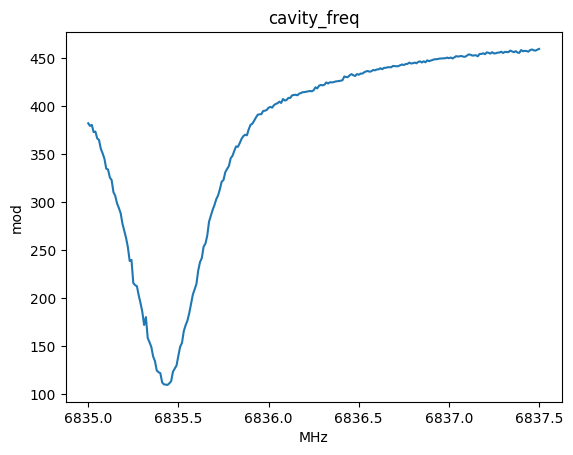

6835.44


In [6]:
param = {
    "sweep_freq": {"start":6835,"end":6837.5,"step":0.1}, ##MHz
    "read_out_ch": 5, 
    "read_in_ch": 1,
    "read_in_pw":2000e-9,
    "read_out_pw":1000e-9,
    "read_out_amp":1,
    "read_out_delay":0e-9,
    "read_in_delay":0e-9,
    "shots":2048,
    "trig_period":50, ##us
    "trig_ch":5,
}

x, y = sweep_freq2(param)
#绘图和数据保存
now_time = datetime.datetime.now().strftime('%H_%M_%S')
plt.plot(x,y)
plt.title("cavity_freq")
plt.xlabel('MHz')
plt.ylabel('mod')#
plt.savefig(f'./data_qcs/cavity_freq/{QUbit}_{now_time}.png')
plt.show()
d = {'x_cavity_freq':x, 'y_mod':y}
df = pd.DataFrame(data=d)
df.to_csv(f'./data_qcs/cavity_freq/{QUbit}_{now_time}.csv')
maxmodindex = np.argmin(y)
print(x[maxmodindex])

### 2.读取腔色散频移扫描

In [7]:
def sweep_qa_power_freq(param):
    for i in range(14):
        dev.dac_close(i)
    for i in range(14,21,1):
        dev.set_ch_offset(i, 0)


    trigger_source = 1    #触发来源，1为外部触发，0为内部触发
    trigger_us = param['trig_period']      #内部触发周期，us
    trigger_continue = 0  #内部触发连续触发模式，1开启，0关闭

    #开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
    trigger_parameter = {
        'trigger_source':0,
        'trigger_continue':trigger_continue,
        'trigger_block_en':1,
        'trigger_ref':0,
        'trigger_times':param['shots'],
        'trigger_us':trigger_us,
        'trigger_delay':0
    }
    dev_ctp.trigger_ctrl(param['trig_ch'], trigger_parameter)

    z_mod = []
    x = np.around(np.linspace(param['sweep_amp']['start'], param['sweep_amp']['end'], 
                              round(abs(param['sweep_amp']['end'] - param['sweep_amp']['start'])/param['sweep_amp']['step']) + 1), 2)
    y = np.around(np.linspace(param['sweep_freq']['start'], param['sweep_freq']['end'], 
                              round(abs(param['sweep_freq']['end'] - param['sweep_freq']['start'])/param['sweep_freq']['step']) + 1), 2)
    for temp_amp in x:
        power = temp_amp
        iq_mod_data = []
        for freq in y:
            dev.trigger_close()
            dev_ctp.trigger_close()

            set_freq(param['read_out_ch'], freq, param['read_out_pw'], amp=power, delay=param['read_out_delay'])
            time.sleep(0.001)
            ad_trigger_delay = (260e-9 + param['read_in_delay']) * 2.5e9  #AD采集延迟，样点数量，用户可以根据采样率5Gsps和时间计算取整后得到
            mul_start_phase = 0     #解模参数：初相
            mul_f_freq = (freq) * 1e6    #解模参数：频率，一般每个qubit对应不同频率
            mul_f_len = int(param['read_in_pw'] * 2.5e9)       #解模参数：单次解模shot数据样点数量 

            mul_f = [[mul_start_phase, mul_f_freq]]    #解模参数列表，最多32组，对应一条线路上的32qubit
            dev.rd_adc_mul_data_ctrl(param['read_in_ch'], ad_trigger_delay, param['shots'], mul_f_len, mul_f)


            dev.trigger_ctrl(trigger_source, trigger_us,param['shots'], trigger_continue)
            dev_ctp.trigger_open()

            #稍作延迟
            time.sleep(0.001)
            # print(11)
            while 1:
                mul_data_bufe,read_data_len = dev.rd_adc_mul_data(param['read_in_ch'],0,param['shots'])
                if read_data_len != -1:
                    break
            # print(22)
            for i in range(read_data_len):
                mul_data_bufe[i] = complex(mul_data_bufe[i])

            iq_lh = np.mean(mul_data_bufe) / mul_f_len / (2**13-1) /temp_amp
            iq_mod_data.append(np.abs(iq_lh))
        z_mod.append(iq_mod_data)

    return x, y, z_mod
            

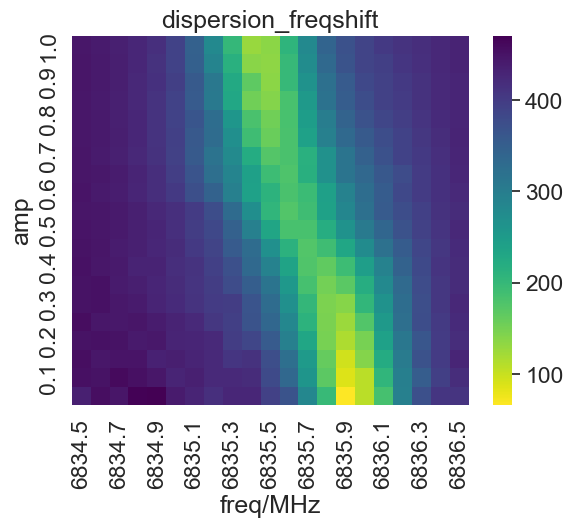

In [8]:
param = {
    "sweep_freq": {"start":6834.5,"end":6836.5,"step":0.1}, ##MHz
    "sweep_amp":{"start":1,"end":0.05,"step":0.05},
    "read_out_ch": 5, 
    "read_in_ch": 1,
    "read_in_pw":2000e-9,
    "read_out_pw":1000e-9,
    "read_out_delay":0e-9,
    "read_in_delay":0e-9,
    "shots":2048,
    "trig_period":100, ##us
    "trig_ch":5,
}

x, y, z = sweep_qa_power_freq(param)

##绘图和保存数据
sns.set(font_scale=1.5)
df = pd.DataFrame(data=z, index=x ,columns=y)
now_time = datetime.datetime.now().strftime('%H_%M_%S')
sns.heatmap(df,cmap="viridis_r")
plt.title("dispersion_freqshift")
plt.xlabel('freq/MHz')
plt.ylabel('amp')
plt.savefig(f'./data_qcs/dispersion_freqshift/{QUbit}_{now_time}.png')
df.to_csv(f'./data_qcs/dispersion_freqshift/{QUbit}_{now_time}.csv')

### 3.能谱腔频实验

In [9]:
def sweep_z_qa_freq(param):
    for i in range(14):
        dev.dac_close(i)
        set_freq(i, 0, 2e-6, 0, delay=0e-9)
    for i in range(14,21,1):
        dev.set_ch_offset(i, 0)
    trigger_source = 1    #触发来源，1为外部触发，0为内部触发
    trigger_us = param['trig_period']      #内部触发周期，us
    trigger_continue = 0  #内部触发连续触发模式，1开启，0关闭

    #开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
    trigger_parameter = {
        'trigger_source':0,
        'trigger_continue':trigger_continue,
        'trigger_block_en':1,
        'trigger_ref':0,
        'trigger_times':param['shots'],
        'trigger_us':trigger_us,
        'trigger_delay':0
    }
    dev_ctp.trigger_ctrl(param['trig_ch'],trigger_parameter)
    z_mod = []
    x = np.around(np.linspace(param['sweep_z_amp']['start'], param['sweep_z_amp']['end'],
                     round(abs(param['sweep_z_amp']['end'] - param['sweep_z_amp']['start'])/param['sweep_z_amp']['step']) + 1), 2)
    y = np.around(np.linspace(param['sweep_cavity_freq']['start'], param['sweep_cavity_freq']['end'], 
                              round(abs(param['sweep_cavity_freq']['end'] - param['sweep_cavity_freq']['start'])/param['sweep_cavity_freq']['step']) + 1), 2)
    for temp_amp in x:
        iq_mod_data = []
        dev.dac_close(0)
        dev.set_ch_offset(param['z_ch'], temp_amp)
        time.sleep(0.001)
        
        for freq in y:
            dev.trigger_close()
            dev_ctp.trigger_close()
            set_freq(param['read_out_ch'], freq, param['read_out_pw'], amp=param['read_out_amp'], delay=param['read_out_delay'])
            time.sleep(0.001)
            ad_trigger_delay = (260e-9 + param['read_in_delay']) * 2.5e9  #AD采集延迟，样点数量，用户可以根据采样率5Gsps和时间计算取整后得到
            mul_start_phase = 0     #解模参数：初相
            mul_f_freq = (freq) * 1e6    #解模参数：频率，一般每个qubit对应不同频率
            mul_f_len = round(param['read_in_pw'] * 2.5e9)       #解模参数：单次解模shot数据样点数量 

            mul_f = [[mul_start_phase, mul_f_freq]]    #解模参数列表，最多32组，对应一条线路上的32qubit
            dev.rd_adc_mul_data_ctrl(param['read_in_ch'],ad_trigger_delay,param['shots'],mul_f_len,mul_f)

            dev.trigger_ctrl(trigger_source,trigger_us,param['shots'],trigger_continue)
            dev_ctp.trigger_open()
            time.sleep(0.001)

            #稍作延迟
            time.sleep(0.001)

            while 1:
                mul_data_bufe,read_data_len = dev.rd_adc_mul_data(param['read_in_ch'],0,param['shots'])
                if read_data_len != -1:
                    break
                
            for i in range(read_data_len):
                mul_data_bufe[i] = complex(mul_data_bufe[i])

            iq_lh = np.mean(mul_data_bufe) / mul_f_len / (2**13-1)
            iq_mod_data.append(np.abs(iq_lh))
        z_mod.append(iq_mod_data)
        
    return x, y, z_mod

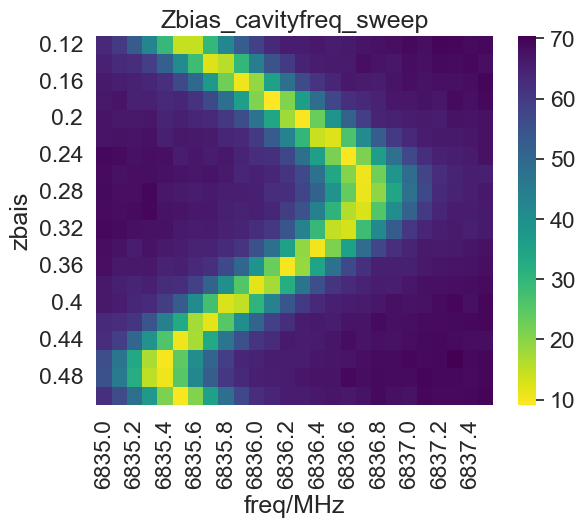

In [10]:
param = {
    "sweep_cavity_freq": {"start":6835,"end":6837.5,"step":0.1}, ##MHz
    "sweep_z_amp":{"start":0.12,"end":0.5,"step":0.02},
    "read_out_ch": 5, 
    "read_in_ch": 1,
    "read_in_pw":2000e-9,
    "read_out_pw":1000e-9,
    "read_out_amp":0.15,
    "read_out_delay":0e-9,
    "read_in_delay":0e-9,
    "shots":2048,
    "trig_period":50, ##us
    "trig_ch":5,
    "z_ch":14,
}

x, y, z = sweep_z_qa_freq(param)
df = pd.DataFrame(data=z, index=x,columns=y)
now_time = datetime.datetime.now().strftime('%H_%M_%S')

sns.heatmap(df,cmap="viridis_r")
plt.title("Zbias_cavityfreq_sweep")
plt.xlabel('freq/MHz')
plt.ylabel('zbais')
plt.savefig(f'./data_qcs/Zbias_cavityfreq_sweep/{QUbit}_{now_time}.png')
plt.show()
df.to_csv(f'./data_qcs/Zbias_cavityfreq_sweep/{QUbit}_{now_time}.csv')

### 4.细扫腔频

In [11]:
def sweep_freq1(param):
    for i in range(14):
        dev.dac_close(i)
        set_freq(i, 0, 2e-6, 0, delay=0e-9)
    for i in range(14,21,1):
        dev.set_ch_offset(i, 0)
    dev.set_ch_offset(param['z_ch'],param['zbias'])
    temp_data = [] 
    y_mod = []

    trigger_source = 1    #触发来源，1为外部触发，0为内部触发
    trigger_us = param['trig_period']      #内部触发周期，us
    trigger_continue = 0  #内部触发连续触发模式，1开启，0关闭

    #开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
    trigger_parameter = {
        'trigger_source':0,
        'trigger_continue':trigger_continue,
        'trigger_block_en':1,
        'trigger_ref':0,
        'trigger_times':param['shots'],
        'trigger_us':trigger_us,
        'trigger_delay':0
    }
    dev_ctp.trigger_ctrl(param['trig_ch'], trigger_parameter)

    x = np.around(np.linspace(param['sweep_freq']['start'], param['sweep_freq']['end'], 
                              round(abs(param['sweep_freq']['end'] - param['sweep_freq']['start'])/param['sweep_freq']['step']) + 1), 2)
    for freq in x:
        dev.trigger_close()
        dev_ctp.trigger_close()

        set_freq(param['read_out_ch'], freq, param['read_out_pw'], amp=param['read_out_amp'],delay=param['read_out_delay'])

        #解模参数配置
        ad_trigger_delay = (260e-9 + param['read_in_delay'])*2.5e9  #AD采集延迟，样点数量，用户可以根据采样率5Gsps和时间计算取整后得到
        mul_start_phase = 0     #解模参数：初相
        mul_f_freq = (freq) * 1e6    #解模参数：频率，一般每个qubit对应不同频率
        mul_f_len = round(param['read_in_pw'] * 2.5e9)       #解模参数：单次解模shot数据样点数量 
        mul_f = [[mul_start_phase, mul_f_freq]]    #解模参数列表，最多32组，对应一条线路上的32qubit
        
        dev.rd_adc_mul_data_ctrl(param['read_in_ch'],ad_trigger_delay,param['shots'],mul_f_len,mul_f)
        dev.trigger_ctrl(trigger_source,trigger_us,param['shots'],trigger_continue)
        dev_ctp.trigger_open()

        #稍作延迟
        time.sleep(0.001)
        # print(22)
        while 1:
            mul_data_bufe,read_data_len = dev.rd_adc_mul_data(param['read_in_ch'],0,param['shots'])
            if read_data_len != -1:
                break
            
        for i in range(read_data_len):
            mul_data_bufe[i] = complex(mul_data_bufe[i])

        # print(11)
        
        temp_data.append(np.mean(mul_data_bufe))
        y_mod = np.abs(np.asarray(temp_data) /mul_f_len / (2**13-1))
    return x, y_mod

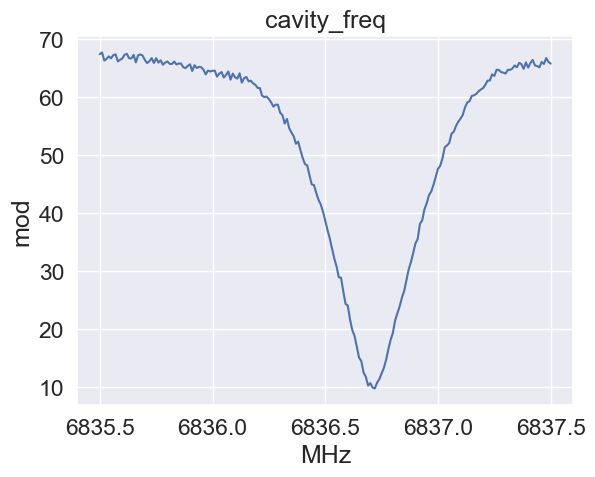

6836.72


In [14]:
param = {
    "sweep_freq": {"start":6835.5,"end":6837.5,"step":0.01}, ##MHz
    "read_out_ch": 5, 
    "read_in_ch": 1,
    "read_in_pw":2000e-9,
    "read_out_pw":1000e-9,
    "read_out_amp":0.15,
    "read_out_delay":0e-9,
    "read_in_delay":0e-9,
    "shots":4000,
    "trig_period":50, ##us
    "trig_ch":5,
    "zbias":0.28,
    "z_ch":14,
}
x, y = sweep_freq1(param)
#绘图和数据保存
now_time = datetime.datetime.now().strftime('%H_%M_%S')
plt.plot(x,y)
plt.title("cavity_freq")
plt.xlabel('MHz')
plt.ylabel('mod')#
plt.savefig(f'./data_qcs/cavity_freq_fine/{QUbit}_{now_time}.png')
plt.show()
d = {'x_cavity_freq':x, 'y_mod':y}
df = pd.DataFrame(data=d)
df.to_csv(f'./data_qcs/cavity_freq_fine/{QUbit}_{now_time}.csv')
maxmodindex = np.argmin(y)
print(x[maxmodindex])

### 5.扫bit频率 f01

In [16]:
def sweep_xy_freq(param):
    for i in range(14):
        dev.dac_close(i)
        set_freq(i, 0, 2e-6, 0, delay=0e-9)
    for i in range(14,21,1):
        dev.set_ch_offset(i, 0)

    temp_data = []
    y_mod = []  

    trigger_source = 1    #触发来源，1为外部触发，0为内部触发
    trigger_us = param['trig_period']       #内部触发周期，us
    trigger_continue = 0  #内部触发连续触发模式，1开启，0关闭
    #开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
    trigger_parameter = {
        'trigger_source':0,
        'trigger_continue':trigger_continue,
        'trigger_block_en':1,
        'trigger_ref':0,
        'trigger_times':param['shots'],
        'trigger_us':trigger_us,
        'trigger_delay':0
    }
    dev_ctp.trigger_ctrl(param['trig_ch'],trigger_parameter)
    dev.set_ch_offset(param['z_ch'], param['zbias'])   
    time.sleep(0.001)

    x = np.around(np.linspace(param['sweep_xy_freq']['start'], param['sweep_xy_freq']['end'],
                               round(abs(param['sweep_xy_freq']['end'] - param['sweep_xy_freq']['start'])/param['sweep_xy_freq']['step']) + 1), 2)
    for freq in x:
        dev.trigger_close()
        dev_ctp.trigger_close()
        xy_timelen = param['xy_pw']
        xy_delay = param['xy_delay']
        set_freq(param['read_out_ch'], param['read_out_freq'], param['read_out_pw'], param['read_out_amp'], 
                 delay = xy_delay + xy_timelen + param['read_out_delay'])
        set_freq_xy_gauss(param['xy_ch'], freq, xy_timelen, amp=param['xy_amp'], delay=xy_delay)

        
        ad_fixed_delay = round(260e-9*2.5e9)
        ad_trigger_delay = ad_fixed_delay + int(xy_timelen*2.5e9)  + int(xy_delay * 2.5e9)+ int(param['read_in_delay'] * 2.5e9)#AD采集延迟，样点数量，用户可以根据采样率5Gsps和时间计算取整后得到
        mul_start_phase = 0     #解模参数：初相
        mul_f_freq = param['read_out_freq'] * 1e6    #解模参数：频率，一般每个qubit对应不同频率
        mul_f_len = round(param['read_in_pw'] *2.5e9)            #解模参数：单次解模shot数据样点数量

        mul_f = [[mul_start_phase, mul_f_freq]]    #解模参数列表，最多32组，对应一条线路上的32qubit
        dev.rd_adc_mul_data_ctrl(param['read_in_ch'],ad_trigger_delay,param['shots'],mul_f_len,mul_f)

        dev.trigger_ctrl(trigger_source,trigger_us,param['shots'],trigger_continue)
        dev_ctp.trigger_open()
        #稍作延迟
        time.sleep(0.001)
        while 1:
            mul_data_bufe,read_data_len = dev.rd_adc_mul_data(param['read_in_ch'],0,param['shots'])
            if read_data_len != -1:
                break
            
        for i in range(read_data_len):
            mul_data_bufe[i] = complex(mul_data_bufe[i])

        temp_data.append(np.mean(mul_data_bufe))
        y_mod = np.abs(np.asarray(temp_data) /mul_f_len / (2**13-1))

    return x, y_mod

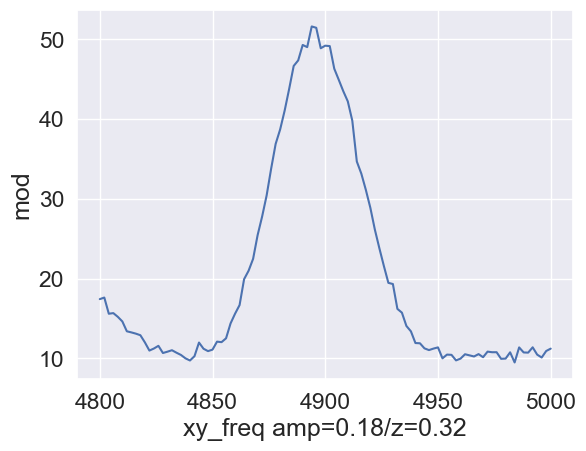

4894.0


In [18]:
param = {
    "sweep_xy_freq": {"start":4880,"end":5000,"step":0.5}, ##MHz
    "read_out_freq":6836.72,
    "read_out_amp": 0.15,
    "zbias":0.28,
    "xy_amp":0.5,
    "xy_ch":6,
    "xy_pw":47e-9,
    "read_out_ch": 5,
    "read_in_ch": 1,
    "read_in_pw":2000e-9,
    "read_out_pw":1000e-9,
    "read_out_delay":0e-9,
    "read_in_delay":0e-9,
    "xy_delay":3e-9,
    "shots":3000,
    "trig_period":200, ##us
    "trig_ch":5,
    "z_ch":14,
}

x, y = sweep_xy_freq(param)

##绘图
now_time = datetime.datetime.now().strftime('%H_%M_%S')
plt.plot(x, y)
plt.xlabel('xy_freq amp=0.18/z=0.32')#
plt.ylabel('mod')
plt.savefig(f'./data_qcs/sweep_xy_freq/{QUbit}_{now_time}.png')
plt.show()
d = {'x_sweep_freq':x, 'y_mod':y}
df = pd.DataFrame(data=d)
df.to_csv(f'./data_qcs/sweep_xy_freq/{QUbit}_{now_time}.csv')
maxmodindex = np.argmax(y)
print(x[maxmodindex])

#### 找bit频率f01的z偏置 2d swiff

In [28]:
def sweep_x_z_y_xyfreq(param):
    for i in range(14):
        dev.dac_close(i)
        set_freq(i, 0, 2e-6, 0, delay=0e-9)
    for i in range(14,21,1):
        dev.set_ch_offset(i, 0)   
    trigger_source = 1    #触发来源，1为外部触发，0为内部触发
    trigger_us = param['trig_period']      #内部触发周期，us
    trigger_continue = 0  #内部触发连续触发模式，1开启，0关闭

    #开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
    trigger_parameter = {
        'trigger_source':0,
        'trigger_continue':trigger_continue,
        'trigger_block_en':1,
        'trigger_ref':0,
        'trigger_times':param['shots'],
        'trigger_us':trigger_us,
        'trigger_delay':0
    }
    dev_ctp.trigger_ctrl(param['trig_ch'],trigger_parameter)
    dev.set_ch_offset(param['z_ch'], param['zbias'])   
    data_list = []

    x = np.around(np.linspace(param['sweep_z_amp']['start'], param['sweep_z_amp']['end'],
                     round(abs(param['sweep_z_amp']['end'] - param['sweep_z_amp']['start'])/param['sweep_z_amp']['step']) + 1), 2)
    
    y = np.around(np.linspace(param['sweep_xy_freq']['start'], param['sweep_xy_freq']['end'],
                               round(abs(param['sweep_xy_freq']['end'] - param['sweep_xy_freq']['start'])/param['sweep_xy_freq']['step']) + 1), 2)
    
    for freq in y:
        IQ_COMPLEX_DATA = []
        for z_amp in x:
            dev.trigger_close()
            dev_ctp.trigger_close()
            dev.set_ch_offset(param['z_ch'], z_amp)

            set_freq_xy_gauss(param['xy_ch'], freq, param['xy_pw'], amp = param['xy_amp'], delay = param['xy_delay'])
            set_freq(param['read_out_ch'], param['read_out_freq'], param['read_out_pw'], amp = param['read_out_amp'], 
                     delay = param['xy_delay'] + param['read_out_delay'] + param['xy_pw'])
            ad_fixed_delay = round(260e-9*2.5e9)
            ad_trigger_delay = ad_fixed_delay + round(param['xy_pw']*2.5e9)  + round(param['xy_delay'] * 2.5e9) + round(param['read_in_delay'] * 2.5e9) #AD采集延迟，样点数量，用户可以根据采样率5Gsps和时间计算取整后得到

            mul_start_phase = 0     #解模参数：初相
            mul_f_freq = param['read_out_freq'] * 1e6    #解模参数：频率，一般每个qubit对应不同频率
            mul_f_len = round(param['read_in_pw']  * 2e9 )      #解模参数：单次解模shot数据样点数量
            mul_f = [[mul_start_phase, mul_f_freq]]    #解模参数列表，最多32组，对应一条线路上的32qubit
            dev.rd_adc_mul_data_ctrl(param['read_in_ch'],ad_trigger_delay,param['shots'] ,mul_f_len,mul_f)

            dev.trigger_ctrl(trigger_source,trigger_us,param['shots'],trigger_continue)
            dev_ctp.trigger_open()
            time.sleep(0.001)
            while 1:
                mul_data_bufe,read_data_len = dev.rd_adc_mul_data(param['read_in_ch'],0,param['shots'])
                if read_data_len != -1:
                    break
            
            for i in range(read_data_len):
                mul_data_bufe[i] = complex(mul_data_bufe[i])

            IQ_COMPLEX_DATA.append(np.abs(np.mean(mul_data_bufe) / mul_f_len / (2**13-1)))
        data_list.append(IQ_COMPLEX_DATA)
    return x, y, data_list

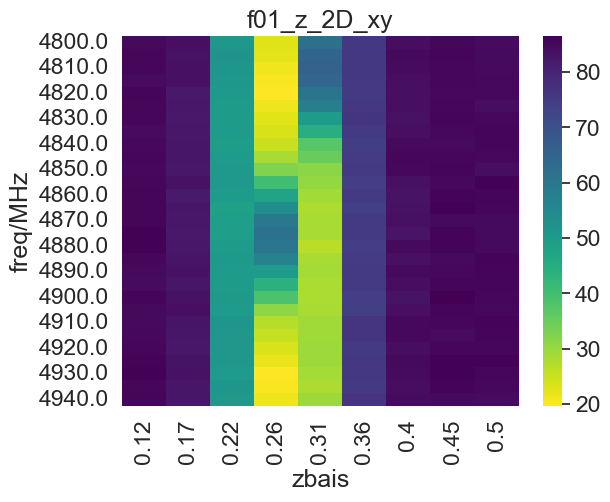

In [27]:
param = {
    "sweep_xy_freq": {"start":4800,"end":4940,"step":5}, ##MHz
    "sweep_z_amp":{"start":0.12,"end":0.5,"step":0.05},    
    "read_out_freq":6836.72,
    "read_out_amp": 0.15,
    "zbias":0.28,
    "xy_amp":0.5,
    "xy_ch":6,
    "xy_pw":30e-9,
    "xy_delay":0e-9,
    "read_out_ch": 5,
    "read_in_ch": 1,
    "read_in_pw":2000e-9,
    "read_out_pw":1000e-9,
    "read_out_delay":0e-9,
    "read_in_delay":0e-9,
    "shots":3000,
    "trig_period":200, ##us
    "trig_ch":5,
    "z_ch":14,
}


# x, y, z = sweep_x_z_y_xyfreq(param)
df = pd.DataFrame(data=z, index=y,columns=x)
now_time = datetime.datetime.now().strftime('%H_%M_%S')
sns.heatmap(df,cmap="viridis_r")
plt.title("f01_z_2D_xy")
plt.xlabel('zbais')
plt.ylabel('freq/MHz')
plt.savefig(f'./data_qcs/f01_z_2D/{QUbit}_{now_time}.png')
plt.show()
df.to_csv(f'./data_qcs/f01_z_2D/{QUbit}_{now_time}.csv')

### 6.RABI幅度

In [30]:
def rabi_test(param):
    for i in range(14):
        dev.dac_close(i)
        set_freq(i, 0, 2e-6, 0, delay=0e-9)
    for i in range(14,21,1):
        dev.set_ch_offset(i, 0)    
    trigger_source = 1    #触发来源，1为外部触发，0为内部触发
    trigger_us = param['trig_period']      #内部触发周期，us
    trigger_continue = 0  #内部触发连续触发模式，1开启，0关闭

    #开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
    trigger_parameter = {
        'trigger_source':0,
        'trigger_continue':trigger_continue,
        'trigger_block_en':1,
        'trigger_ref':0,
        'trigger_times':param['shots'],
        'trigger_us':trigger_us,
        'trigger_delay':0
    }
    dev_ctp.trigger_ctrl(param['trig_ch'],trigger_parameter)

    temp_data = []
    y_mod = []
    dev.set_ch_offset(param['z_ch'], param['zbias'])
    time.sleep(0.001)

    x = np.around(np.linspace(param['sweep_xy_amp']['start'], param['sweep_xy_amp']['end'],
                     round(abs(param['sweep_xy_amp']['end'] - param['sweep_xy_amp']['start'])/param['sweep_xy_amp']['step']) + 1), 2)
    for amp in x:
        xy_timelen = param['xy_pw']
        xy_delay = param['xy_delay']
        set_freq(param['read_out_ch'], param['read_out_freq'], param['read_out_pw'], param['read_out_amp'], 
                 delay = xy_delay + xy_timelen + param['read_out_delay'])
        set_freq_xy_gauss(param['xy_ch'], param['xy_freq'], xy_timelen, amp, delay=xy_delay)
        ad_fixed_delay = round(260e-9*2.5e9)
        ad_trigger_delay = ad_fixed_delay + round(xy_timelen*2.5e9)  + round((xy_delay+param['read_in_delay']) * 2.5e9)#AD采集延迟，样点数量，用户可以根据采样率5Gsps和时间计算取整后得到
        mul_start_phase = 0     #解模参数：初相
        mul_f_freq = param['read_out_freq'] * 1e6    #解模参数：频率，一般每个qubit对应不同频率
        mul_f_len = round(param['read_in_pw'] * 2.5e9)       #解模参数：单次解模shot数据样点数量

        mul_f = [[mul_start_phase, mul_f_freq]]    #解模参数列表，最多32组，对应一条线路上的32qubit
        dev.rd_adc_mul_data_ctrl(param['read_in_ch'],ad_trigger_delay,param['shots'],mul_f_len,mul_f)

        dev.trigger_ctrl(trigger_source,trigger_us,param['shots'],trigger_continue) 
        dev_ctp.trigger_open()
        #稍作延迟
        time.sleep(0.001)
        while 1:
            mul_data_bufe,read_data_len = dev.rd_adc_mul_data(param['read_in_ch'],0,param['shots'])
            if read_data_len != -1:
                break
            
        for i in range(read_data_len):
            mul_data_bufe[i] = complex(mul_data_bufe[i])

        temp_data.append(np.abs(np.mean(mul_data_bufe)))
        y_mod = np.asarray(temp_data) / mul_f_len / 8191
    return x, y_mod

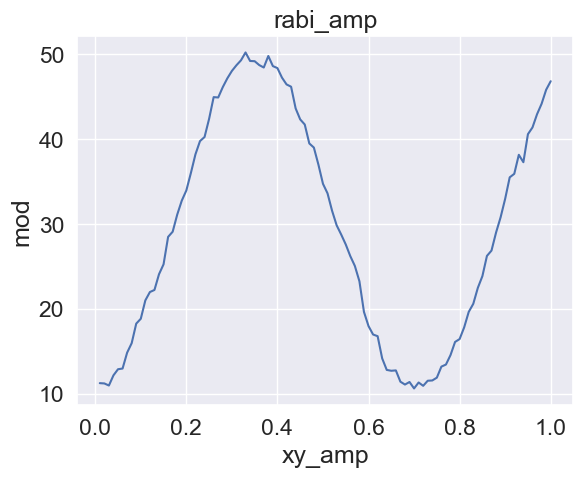

0.33


In [31]:

param = {
    "sweep_xy_amp": {"start":0.01,"end":1,"step":0.01}, ##MHz
    "read_out_freq":6836.72,
    "read_out_amp": 0.15,
    "zbias":0.28,
    "xy_ch":6,
    "xy_pw":40e-9,
    "xy_freq":4898,
    "xy_delay":0e-9,
    "read_out_ch": 5,
    "read_in_ch": 1,
    "read_in_pw":2000e-9,
    "read_out_pw":1000e-9,
    "read_out_delay":0e-9,
    "read_in_delay":0e-9,
    "shots":5000,
    "trig_period":200, ##us
    "trig_ch":5,
    "z_ch":14,
}
x, y = rabi_test(param)

now_time = datetime.datetime.now().strftime('%H_%M_%S')
plt.plot(x, y)
plt.title("rabi_amp")
plt.xlabel('xy_amp')
plt.ylabel('mod')#0.71
plt.savefig(f'./data_qcs/rabi_amp/{QUbit}_{now_time}.png')
plt.show()
d = {'x_xyamp':x, 'y_mod':y}
df = pd.DataFrame(data=d)
df.to_csv(f'./data_qcs/rabi_amp/{QUbit}_{now_time}.csv')
maxmodindex = np.argmax(y)
print(x[maxmodindex])

### 7.rabi脉宽

In [32]:
def rabi_test_len(param):
    for i in range(14):
        dev.dac_close(i)
        set_freq(i, 0, 2e-6, 0, delay=0e-9)
    for i in range(14,21,1):
        dev.set_ch_offset(i, 0)
    temp_data = []
    y_mod = []
    trigger_source = 1    #触发来源，1为外部触发，0为内部触发
    trigger_us = param['trig_period']      #内部触发周期，us
    trigger_continue = 0  #内部触发连续触发模式，1开启，0关闭

    #开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
    trigger_parameter = {
        'trigger_source':0,
        'trigger_continue':trigger_continue,
        'trigger_block_en':1,
        'trigger_ref':0,
        'trigger_times':param['shots'],
        'trigger_us':trigger_us,
        'trigger_delay':0
    }
    dev_ctp.trigger_ctrl(param['trig_ch'],trigger_parameter)
    dev.set_ch_offset(param['z_ch'], param['zbias'])   
    time.sleep(0.001)

    x = np.linspace(param['sweep_xy_pw']['start'], param['sweep_xy_pw']['end'],
                               round(abs(param['sweep_xy_pw']['end'] - param['sweep_xy_pw']['start'])/param['sweep_xy_pw']['step']) + 1)
    for add_delay in x:
        dev.trigger_close()
        dev_ctp.trigger_close()
        xy_timelen = add_delay
        xy_delay = param['xy_delay']
        set_freq(param['read_out_ch'], param['read_out_freq'], param['read_out_pw'],param['read_out_amp'], 
                 delay= xy_timelen + xy_delay + param['read_out_delay'] )
        set_freq_xy_gauss(param['xy_ch'], param['xy_freq'], xy_timelen, amp=param['xy_amp'], delay=xy_delay) #
        ad_fixed_delay = round(260e-9*2.5e9)
        ad_trigger_delay = ad_fixed_delay + round(xy_timelen*2.5e9)  + round(xy_delay * 2.5e9) + round(param['read_in_delay'] * 2.5e9)#AD采集延迟，样点数量，用户可以根据采样率5Gsps和时间计算取整后得到 

        mul_start_phase = 0     #解模参数：初相
        mul_f_freq = param['read_out_freq'] * 1e6    #解模参数：频率，一般每个qubit对应不同频率
        mul_f_len = round(param['read_in_pw']*2.5e9)      #解模参数：单次解模shot数据样点数量

        mul_f = [[mul_start_phase, mul_f_freq]]    #解模参数列表，最多32组，对应一条线路上的32qubit
        dev.rd_adc_mul_data_ctrl(param['read_in_ch'],ad_trigger_delay,param['shots'],mul_f_len,mul_f)

        dev.trigger_ctrl(trigger_source,trigger_us,param['shots'],trigger_continue)
        dev_ctp.trigger_open()

        #稍作延迟
        time.sleep(0.001)

        while 1:
            mul_data_bufe,read_data_len = dev.rd_adc_mul_data(param['read_in_ch'],0,param['shots'])
            if read_data_len != -1:
                break
            
        for i in range(read_data_len):
            mul_data_bufe[i] = complex(mul_data_bufe[i])

        temp_data.append(np.mean(mul_data_bufe))
        y_mod = np.abs(np.asarray(temp_data) / mul_f_len / 8191)
    return  x*1e9, y_mod

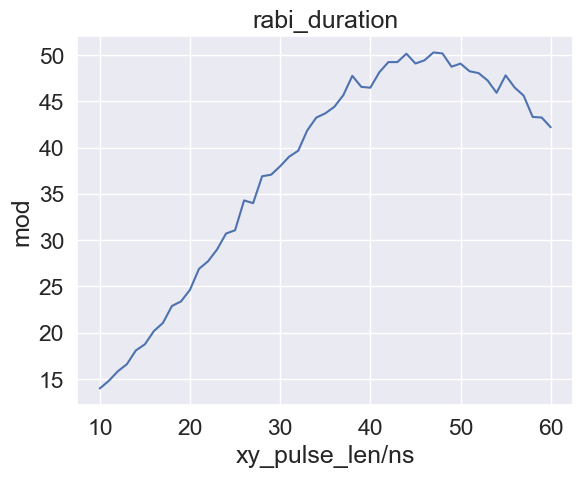

47.0


In [41]:

param = {
    "sweep_xy_pw": {"start":10e-9,"end":60e-9,"step":1e-9}, ##MHz
    "read_out_freq":6836.72,
    "read_out_amp": 0.15,
    "zbias":0.28,
    "xy_amp":0.3,
    "xy_ch":6,
    "xy_freq":4898,
    "xy_delay":0e-9,
    "read_out_ch": 5,
    "read_in_ch": 1,
    "read_in_pw":2000e-9,
    "read_out_pw":1000e-9,
    "read_out_delay":0e-9,
    "read_in_delay":0e-9,
    "shots":4000,
    "trig_period":200, ##us
    "trig_ch":5,
    "z_ch":14,
}
x, y = rabi_test_len(param)

now_time = datetime.datetime.now().strftime('%H_%M_%S')
plt.plot(x,y)
plt.title("rabi_duration")
plt.xlabel('xy_pulse_len/ns')
plt.ylabel('mod')
plt.savefig(f'./data_qcs/rabi_pw/{QUbit}_{now_time}.png')
plt.show()
d = {'x_xy_pluse_witdth':x, 'y_mod':y}
df = pd.DataFrame(data=d)
df.to_csv(f'./data_qcs/rabi_pw/{QUbit}_{now_time}.csv')
maxmodindex = np.argmax(y)
print(x[maxmodindex])

### 8.T1测量

In [36]:
def t1_test(param):
    for i in range(14):
        dev.dac_close(i)
        set_freq(i, 0, 2e-6, 0, delay=0e-9)
    for i in range(14,21,1):
        dev.set_ch_offset(i, 0)
    temp_data = []
    y_mod = []
  
    trigger_source = 1    #触发来源，1为外部触发，0为内部触发
    trigger_us = param['trig_period']      #内部触发周期，us
    trigger_continue = 0  #内部触发连续触发模式，1开启，0关闭

    #开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
    trigger_parameter = {
        'trigger_source':0,
        'trigger_continue':trigger_continue,
        'trigger_block_en':1,
        'trigger_ref':0,
        'trigger_times':param['shots'],
        'trigger_us':trigger_us,
        'trigger_delay':0
    }
    dev_ctp.trigger_ctrl(param['trig_ch'],trigger_parameter)
    dev.set_ch_offset(param['z_ch'], param['zbias']) 

    x = np.linspace(param['sweep_read_delay']['start'], param['sweep_read_delay']['end'],
                    round(abs(param['sweep_read_delay']['end'] - param['sweep_read_delay']['start'])/param['sweep_read_delay']['step']) + 1)
    for add_delay in x:
        dev.trigger_close()
        dev_ctp.trigger_close()
        xy_timelen = param['xy_pw']
        xy_delay = param['xy_delay']        
        set_freq(param['read_out_ch'], param['read_out_freq'], param['read_out_pw'],param['read_out_amp'], delay = xy_timelen + xy_delay + param['read_out_delay'] + add_delay)
        set_freq_xy_gauss(param['xy_ch'], param['xy_freq'], xy_timelen, amp=param['xy_amp'], delay=xy_delay) #
        ad_fixed_delay = round(260e-9*2.5e9)
        ad_trigger_delay = ad_fixed_delay + round(xy_timelen*2.5e9)  + round(xy_delay * 2.5e9) + round(param['read_in_delay']*2.5e9) +  round(add_delay * 2.5e9) 
        mul_start_phase = 0     #解模参数：初相
        mul_f_freq = param['read_out_freq'] * 1e6    #解模参数：频率，一般每个qubit对应不同频率
        mul_f_len = round(param['read_in_pw']*2.5e9)        #解模参数：单次解模shot数据样点数量
        mul_f = [[mul_start_phase, mul_f_freq]]    #解模参数列表，最多32组，对应一条线路上的32qubit
        dev.rd_adc_mul_data_ctrl(param['read_in_ch'],ad_trigger_delay,param['shots'],mul_f_len,mul_f)

        dev.trigger_ctrl(trigger_source,trigger_us,param['shots'],trigger_continue)
        dev_ctp.trigger_open()
        #稍作延迟
        time.sleep(0.001)

        while 1:
            mul_data_bufe,read_data_len = dev.rd_adc_mul_data(param['read_in_ch'],0,param['shots'])
            if read_data_len != -1:
                break
            
        for i in range(read_data_len):
            mul_data_bufe[i] = complex(mul_data_bufe[i])
        
        temp_data.append(np.mean(mul_data_bufe))
        y_mod = np.abs(np.asarray(temp_data) / mul_f_len / 8191)
    return x*1e9, y_mod

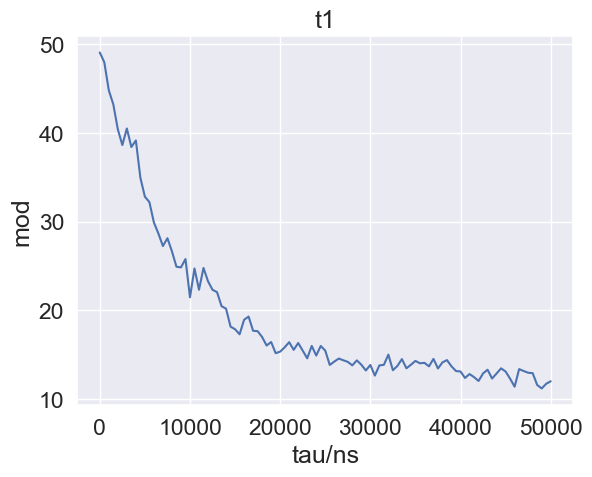

25.140642994642285


In [42]:
param = {
    "sweep_read_delay": {"start":0e-9,"end":50000e-9,"step":500e-9}, ##MHz
    "read_out_freq":6836.72,
    "read_out_amp": 0.15,
    "zbias":0.28,
    "xy_amp":0.3,
    "xy_ch":6,
    "xy_freq":4898,
    "xy_pw":47e-9,
    "xy_delay":3e-9,
    "read_out_ch": 5,
    "read_in_ch": 1,
    "read_in_pw":2000e-9,
    "read_out_pw":1000e-9,
    "read_out_delay":0e-9,
    "read_in_delay":0e-9,
    "shots":4000,
    "trig_period":200, ##us
    "trig_ch":5,
    "z_ch":14,
}
x, y= t1_test(param)

now_time = datetime.datetime.now().strftime('%H_%M_%S')
plt.plot(x,y)
plt.title("t1")
plt.xlabel('tau/ns')
plt.ylabel('mod')#
plt.savefig(f'./data_qcs/t1/{QUbit}_{now_time}.png')
plt.show()
d = {'x_xy_t1':x, 'y_mod':y}
df = pd.DataFrame(data=d)
df.to_csv(f'./data_qcs/t1/{QUbit}_{now_time}.csv')
maxmodindex = (np.max(y)-np.min(y))*(1/np.e) + np.min(y)
print(maxmodindex)

### 9.T2测量

In [45]:
def t2_test(param):
    for i in range(14):
        dev.dac_close(i)
        set_freq(i, 0, 2e-6, 0, delay=0e-9)
    for i in range(14,21,1):
        dev.set_ch_offset(i, 0)

    temp_data = []
    y_mod = []
    trigger_source = 1    #触发来源，1为外部触发，0为内部触发
    trigger_us = param['trig_period']      #内部触发周期，us
    trigger_continue = 0  #内部触发连续触发模式，1开启，0关闭

    #开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
    trigger_parameter = {
        'trigger_source':0,
        'trigger_continue':trigger_continue,
        'trigger_block_en':1,
        'trigger_ref':0,
        'trigger_times':param['shots'],
        'trigger_us':trigger_us,
        'trigger_delay':0
    }
    dev_ctp.trigger_ctrl(param['trig_ch'],trigger_parameter)
    dev.set_ch_offset(param['z_ch'], param['zbias'])   

    x = np.linspace(param['sweep_t_delay']['start'], param['sweep_t_delay']['end'],
                        round(abs(param['sweep_t_delay']['end'] - param['sweep_t_delay']['start'])/param['sweep_t_delay']['step']) + 1)
    for t in x: 
        dev.trigger_close()
        dev_ctp.trigger_close()       
        xy_one_pluse_timelen = param['xy_pw']
        xy_delay = param['xy_delay']
        ad_fixed_delay = round(260e-9*2.5e9)
        xy_all_timelen = xy_one_pluse_timelen * 2 + t   
        set_freq(param['read_out_ch'], param['read_out_freq'], param['read_out_pw'],param['read_out_amp'], delay = xy_all_timelen + xy_delay + param['read_out_delay'])
        set_xy_two_pluse_t_gauss(param['xy_ch'], param['xy_freq'], xy_one_pluse_timelen, amp=param['xy_amp'], t_s = t,t_delay=xy_delay)
        # set_freq(param['xy_ch'], param['xy_freq'], xy_one_pluse_timelen, amp=param['xy_amp'], delay=xy_delay) #       
        ad_trigger_delay = ad_fixed_delay + round(xy_all_timelen*2.5e9)  + round(xy_delay * 2.5e9) + round(param['read_in_delay']*2.5e9) 
        shots = 2048
        mul_start_phase = 0     #解模参数：初相
        mul_f_freq = param['read_out_freq'] * 1e6    #解模参数：频率，一般每个qubit对应不同频率
        mul_f_len = round(param['read_in_pw']*2.5e9)        #解模参数：单次解模shot数据样点数量
        mul_f = [[mul_start_phase, mul_f_freq]]    #解模参数列表，最多32组，对应一条线路上的32qubit
        dev.rd_adc_mul_data_ctrl(param['read_in_ch'],ad_trigger_delay,shots,mul_f_len,mul_f)

        dev.trigger_ctrl(trigger_source,trigger_us,param['shots'],trigger_continue)
        dev_ctp.trigger_open()

        #稍作延迟
        time.sleep(0.001)
        while 1:
            mul_data_bufe,read_data_len = dev.rd_adc_mul_data(param['read_in_ch'],0,param['shots'])
            if read_data_len != -1:
                break
        
        for i in range(read_data_len):
            mul_data_bufe[i] = complex(mul_data_bufe[i])

        temp_data.append(np.mean(mul_data_bufe))
        y_mod = np.abs(np.asarray(temp_data) / mul_f_len / 8191)
        # print(y_mod)

    return x*1e9, y_mod

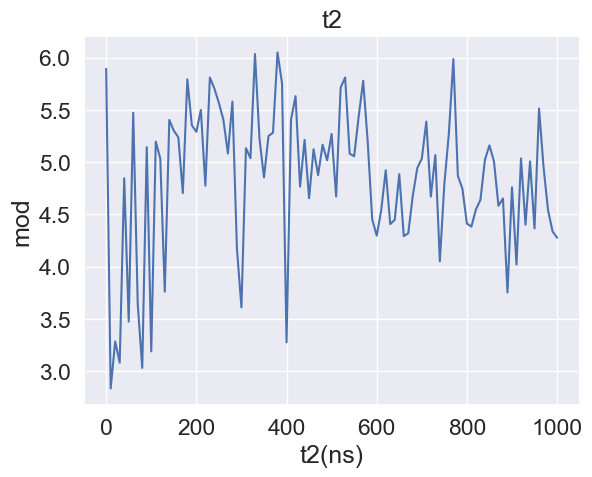

In [48]:
param = {
    "sweep_t_delay": {"start":0e-9,"end":1000e-9,"step":50e-9}, ##MHz
    "read_out_freq":6836.72,
    "read_out_amp": 0.15,
    "zbias":0.28,
    "xy_amp":0.2,
    "xy_ch":6,
    "xy_freq":4850,
    "xy_pw":47e-9,
    "xy_delay":3e-9,
    "read_out_ch": 5,
    "read_in_ch": 1,
    "read_in_pw":2000e-9,
    "read_out_pw":1000e-9,
    "read_out_delay":0e-9,
    "read_in_delay":0e-9,
    "shots":3000,
    "trig_period":200, ##us
    "trig_ch":5,
    "z_ch":14,
}

x, y = t2_test(param)

now_time = datetime.datetime.now().strftime('%H_%M_%S')
plt.plot(x,y)
plt.title("t2")
plt.xlabel('t2(ns)')
plt.ylabel('mod')
plt.savefig(f'./data_qcs/t2/{QUbit}_{now_time}.png')
plt.show()
d = {'x_xy_t2':x, 'y_mod':y}
df = pd.DataFrame(data=d)
df.to_csv(f'./data_qcs/t2/{QUbit}_{now_time}.csv')


### 10.01态 IQ 图

In [49]:
def qubit_01_stateIQ(param):
    for i in range(14):
        dev.dac_close(i)
        set_freq(i, 0, 2e-6, 0, delay=0e-9)
    for i in range(14,21,1):
        dev.set_ch_offset(i, 0)
        
    dev.trigger_close()
    dev_ctp.trigger_close()
    ad_samp = 2.5e9
    dev.set_ch_offset(param['z_ch'], param['zbias']) 
    
    set_freq(param['read_out_ch'], param['read_out_freq'], param['read_out_pw'], 
             param['read_out_amp'], param['read_out_delay'] + param['xy_pw'] + param['xy_delay'] )
    if param['01_state'] == 0:# 0态-不给任何信号
        set_freq_xy_gauss(param['xy_ch'], param['xy_freq'], 
                          param['xy_pw'], param['xy_amp_0state'], param['xy_delay'] ) 
    elif param['01_state'] == 1: # 1态-XY给高斯脉冲
        set_freq_xy_gauss(param['xy_ch'], param['xy_freq'], 
                          param['xy_pw'], param['xy_amp_1state'], param['xy_delay'] ) 
    elif param['01_state'] == 2: # 叠加态
        set_freq_xy_gauss(param['xy_ch'], param['xy_freq'], 
                          param['xy_pw'], param['xy_amp_muxstate'], param['xy_delay'] )   
    else:
        pass

    ad_fixed_delay =260e-9 
    ad_trigger_delay = round((ad_fixed_delay + param['xy_pw'] + param['xy_delay'] 
                              +  param['read_in_delay'] ) * ad_samp) 
    shots = param['shots']           #解模次数
    mul_start_phase = 0    #解模参数：初相
    mul_f_freq = param['read_out_freq'] * 1e6    #解模参数：频率，一般每个qubit对应不同频率
    mul_f_len = round(param['read_in_pw']  *2.5e9)       # 解模参数：单次解模shot数据样点数量 
    
    mul_f = [[mul_start_phase, mul_f_freq]]    #解模参数列表，最多32组，对应一条线路上的32qubit
    dev.rd_adc_mul_data_ctrl(param['read_in_ch'],ad_trigger_delay,shots,mul_f_len,mul_f)

    trigger_source = 1    #触发来源，1为外部触发，0为内部触发
    trigger_us = param['trig_period']      #内部触发周期，us
    trigger_continue = 0  #内部触发连续触发模式，1开启，0关闭
    #开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
    trigger_parameter = {
        'trigger_source':0,
        'trigger_continue':trigger_continue,
        'trigger_block_en':1,
        'trigger_ref':0,
        'trigger_times':shots,
        'trigger_us':trigger_us,
        'trigger_delay':0
    }
    dev.trigger_ctrl(trigger_source,trigger_us,shots,trigger_continue)
    dev_ctp.trigger_ctrl(param['trig_ch'],trigger_parameter)
    dev_ctp.trigger_open()
    time.sleep(0.001)

    #稍作延迟
    time.sleep(0.001)

    while 1:
        mul_data_bufe,read_data_len = dev.rd_adc_mul_data(param['read_in_ch'],0,shots)
        if read_data_len != -1:
            break

    real,imag=[],[]    
    for i in range(read_data_len):
        mul_data_bufe[i] = complex(mul_data_bufe[i])
        real.append(mul_data_bufe[i].real/mul_f_len)
        imag.append(mul_data_bufe[i].imag/mul_f_len)
        
    return real,imag,np.abs(np.mean(mul_data_bufe)/mul_f_len/(2**13-1))

25.485856828906545
82.24283255779103


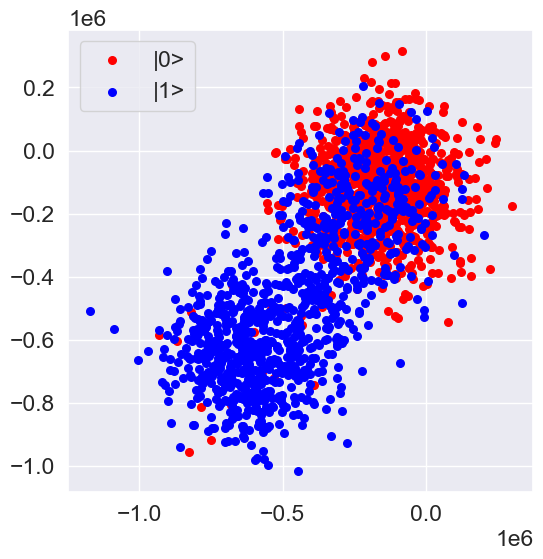

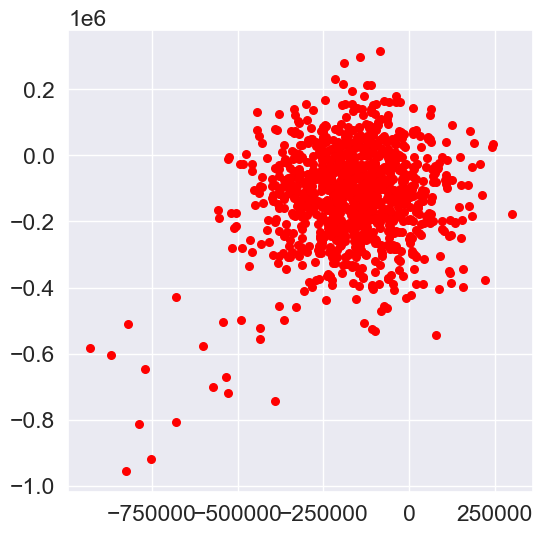

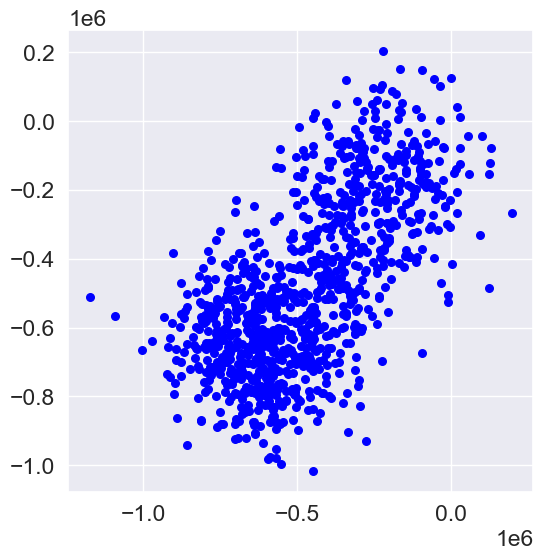

In [63]:
param = {
    "01_state": 0, 
    "read_out_freq":6836.72,
    "read_out_amp": 0.15,
    "zbias":0.28,
    "xy_ch":6,
    "xy_amp_0state":0,    
    "xy_amp_1state":0.3,  
    "xy_amp_muxstate":0.2,       
    "xy_pw":46e-9,
    "xy_freq":4898.5,
    "xy_delay":4e-9,
    "read_out_ch": 5,
    "read_in_ch": 1,
    "read_in_pw":5000e-9,
    "read_out_pw":5000e-9,
    "read_out_delay":0e-9,
    "read_in_delay":0e-9,
    "shots":1000,
    "trig_period":200, ##us
    "trig_ch":5,
    "z_ch":14,
}

x0,y0,mod0 = qubit_01_stateIQ(param)
print(mod0)
param["01_state"]=1
x1,y1,mod1 = qubit_01_stateIQ(param)
print(mod1)

now_time = datetime.datetime.now().strftime('%H_%M_%S')
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)
type1 = ax.scatter(x0, y0, s = 30, c = 'red')
type2 = ax.scatter(x1, y1, s = 30, c = 'blue')
ax.legend((type1, type2), ("|0>", "|1>"), loc = 0)
plt.show()

fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)
type1 = ax.scatter(x0, y0, s = 30, c = 'red')
plt.show()

fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)
type2 = ax.scatter(x1, y1, s = 30, c = 'blue')
plt.show()

d = {'I0':x0, 'Q0':y0 ,'I1':x1, 'Q1':y1}
df = pd.DataFrame(data=d)
df.to_csv(f'./data_qcs/mod_ref/Q8_01_{mod0}_{now_time}.csv')

### 11.01态扫腔频

In [64]:
def sweep_freq_0state(param):
    for i in range(14):
        dev.dac_close(i)
        set_freq(i, 0, 2e-6, 0, delay=0e-9)
    for i in range(14,21,1):
        dev.set_ch_offset(i, 0)
    dev.set_ch_offset(param['z_ch'],param['zbias'])
    temp_data = [] 
    y_mod = []

    trigger_source = 1    #触发来源，1为外部触发，0为内部触发
    trigger_us = param['trig_period']      #内部触发周期，us
    trigger_continue = 0  #内部触发连续触发模式，1开启，0关闭

    #开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
    trigger_parameter = {
        'trigger_source':0,
        'trigger_continue':trigger_continue,
        'trigger_block_en':1,
        'trigger_ref':0,
        'trigger_times':param['shots'],
        'trigger_us':trigger_us,
        'trigger_delay':0
    }
    dev_ctp.trigger_ctrl(param['trig_ch'], trigger_parameter)

    x = np.around(np.linspace(param['sweep_freq']['start'], param['sweep_freq']['end'], 
                              round(abs(param['sweep_freq']['end'] - param['sweep_freq']['start'])/param['sweep_freq']['step']) + 1), 2)
    for freq in x:
        dev.trigger_close()
        dev_ctp.trigger_close()

        set_freq(param['read_out_ch'], freq, param['read_out_pw'], amp=param['read_out_amp'],
                 delay=param['read_out_delay'] + param['xy_pw'] + param['xy_delay'] )
        set_freq_xy_gauss(param['xy_ch'], param['xy_freq'], 
                          param['xy_pw'], 0, param['xy_delay']) 
        #解模参数配置
        ad_fixed_delay =260e-9 
        ad_trigger_delay = round((ad_fixed_delay + param['xy_pw'] + param['xy_delay'] 
                                +  param['read_in_delay'] ) * 2.5e9) 
        mul_start_phase = 0     #解模参数：初相
        mul_f_freq = (freq) * 1e6    #解模参数：频率，一般每个qubit对应不同频率
        mul_f_len = round(param['read_in_pw'] * 2.5e9)       #解模参数：单次解模shot数据样点数量 
        mul_f = [[mul_start_phase, mul_f_freq]]    #解模参数列表，最多32组，对应一条线路上的32qubit
        
        dev.rd_adc_mul_data_ctrl(param['read_in_ch'],ad_trigger_delay,param['shots'],mul_f_len,mul_f)
        dev.trigger_ctrl(trigger_source,trigger_us,param['shots'],trigger_continue)
        dev_ctp.trigger_open()

        #稍作延迟
        time.sleep(0.001)
        # print(22)
        while 1:
            mul_data_bufe,read_data_len = dev.rd_adc_mul_data(param['read_in_ch'],0,param['shots'])
            if read_data_len != -1:
                break
            
        for i in range(read_data_len):
            mul_data_bufe[i] = complex(mul_data_bufe[i])

        # print(11)
        
        temp_data.append(np.mean(mul_data_bufe))
        y_mod = np.abs(np.asarray(temp_data) /mul_f_len / (2**13-1))
    return x, y_mod

def sweep_freq_1state(param):
    for i in range(14):
        dev.dac_close(i)
        set_freq(i, 0, 2e-6, 0, delay=0e-9)
    for i in range(14,21,1):
        dev.set_ch_offset(i, 0)
    dev.set_ch_offset(param['z_ch'],param['zbias'])
    temp_data = [] 
    y_mod = []

    trigger_source = 1    #触发来源，1为外部触发，0为内部触发
    trigger_us = param['trig_period']      #内部触发周期，us
    trigger_continue = 0  #内部触发连续触发模式，1开启，0关闭

    #开启触发信号使能，此时等待外部触发信号触发DA输出与AD采集
    trigger_parameter = {
        'trigger_source':0,
        'trigger_continue':trigger_continue,
        'trigger_block_en':1,
        'trigger_ref':0,
        'trigger_times':param['shots'],
        'trigger_us':trigger_us,
        'trigger_delay':0
    }
    dev_ctp.trigger_ctrl(param['trig_ch'], trigger_parameter)

    x = np.around(np.linspace(param['sweep_freq']['start'], param['sweep_freq']['end'], 
                              round(abs(param['sweep_freq']['end'] - param['sweep_freq']['start'])/param['sweep_freq']['step']) + 1), 2)
    for freq in x:
        dev.trigger_close()
        dev_ctp.trigger_close()

        set_freq(param['read_out_ch'], freq, param['read_out_pw'], amp=param['read_out_amp'],
                 delay=param['read_out_delay'] + param['xy_pw'] + param['xy_delay'] )
        set_freq_xy_gauss(param['xy_ch'], param['xy_freq'], 
                          param['xy_pw'], param['xy_amp'], param['xy_delay']) 
        #解模参数配置
        ad_fixed_delay =260e-9 
        ad_trigger_delay = round((ad_fixed_delay + param['xy_pw'] + param['xy_delay'] 
                                +  param['read_in_delay'] ) * 2.5e9) 
        mul_start_phase = 0     #解模参数：初相
        mul_f_freq = (freq) * 1e6    #解模参数：频率，一般每个qubit对应不同频率
        mul_f_len = round(param['read_in_pw'] * 2.5e9)       #解模参数：单次解模shot数据样点数量 
        mul_f = [[mul_start_phase, mul_f_freq]]    #解模参数列表，最多32组，对应一条线路上的32qubit
        
        dev.rd_adc_mul_data_ctrl(param['read_in_ch'],ad_trigger_delay,param['shots'],mul_f_len,mul_f)
        dev.trigger_ctrl(trigger_source,trigger_us,param['shots'],trigger_continue)
        dev_ctp.trigger_open()

        #稍作延迟
        time.sleep(0.001)
        # print(22)
        while 1:
            mul_data_bufe,read_data_len = dev.rd_adc_mul_data(param['read_in_ch'],0,param['shots'])
            if read_data_len != -1:
                break
            
        for i in range(read_data_len):
            mul_data_bufe[i] = complex(mul_data_bufe[i])

        # print(11)
        
        temp_data.append(np.mean(mul_data_bufe))
        y_mod = np.abs(np.asarray(temp_data) /mul_f_len / (2**13-1))
    return x, y_mod


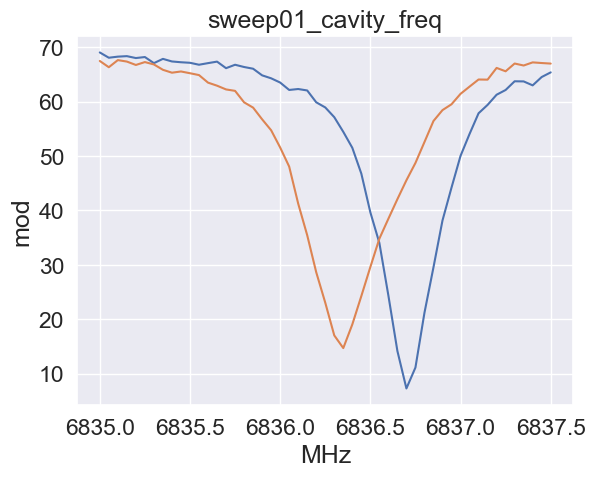

10.0


In [66]:
param = {
    "sweep_freq": {"start":6835,"end":6837.5,"step":0.05}, ##MHz
    "read_out_freq":6836.72,
    "read_out_amp": 0.15,
    "zbias":0.28,
    "xy_amp":0.3,
    "xy_ch":6,
    "xy_freq":4898,
    "xy_pw":47e-9,
    "xy_delay":3e-9,
    "read_out_ch": 5,
    "read_in_ch": 1,
    "read_in_pw":3000e-9,
    "read_out_pw":1500e-9,
    "read_out_delay":0e-9,
    "read_in_delay":0e-9,
    "shots":2048,
    "trig_period":200, ##us
    "trig_ch":5,
    "z_ch":14,
}
I0, Q0 = sweep_freq_0state(param)
I1, Q1 = sweep_freq_1state(param)
QUbit = 'Q8'
#绘图和数据保存
now_time = datetime.datetime.now().strftime('%H_%M_%S')
plt.plot( I0 , Q0 , I1 , Q1 )
plt.title("sweep01_cavity_freq")
plt.xlabel('MHz')
plt.ylabel('mod')#
plt.savefig(f'./data_qcs/sweep01_cavity_freq/{QUbit}_{now_time}.png')
plt.show()
d = {'x_cavity_freq':x, 'y_mod':y}
df = pd.DataFrame(data=d)
df.to_csv(f'./data_qcs/sweep01_cavity_freq/{QUbit}_{now_time}.csv')
maxmodindex = np.argmin(y)
print(x[maxmodindex])

### end